In [1]:
# these are common imports for every notebook
# pandas and numpy are for analysis
# matplotlib and seaborn are for visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/sansbacon/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Initial Datasets

In [2]:
# read dataset
qb = pd.read_csv('data/qb_yearly.csv')

In [3]:
qb.dtypes

source_player_id             object
source_player_name           object
season_year                   int64
age                           int64
pos                          object
g                             int64
gs                            int64
pass_cmp                      int64
pass_att                      int64
pass_cmp_perc               float64
pass_yds                      int64
pass_td                       int64
pass_int                      int64
pass_adj_yds_per_att        float64
pass_adj_net_yds_per_att    float64
dtype: object

In [4]:
# we don't need a few of these columns
qb = qb.drop(['gs', 'pos', 'pass_cmp_perc'], axis=1)

In [5]:
# drop seasons with less than 100 pass attempts
# this should filter out non-QBs who threw some passes
# as well as very marginal players
qb = qb.loc[qb['pass_att'] >= 100, :]

In [6]:
# rename some columns
renames = {
    'source_player_name': 'player',
    'source_player_id': 'player_id',
    'pass_adj_yds_per_att': 'aya',
    'pass_adj_net_yds_per_att': 'anya'
}

qb = qb.rename(columns=renames)

# convert columns to string
qb['player'] = qb['player'].astype('string')
qb['player_id'] = qb['player_id'].astype('string')

In [7]:
# check missing values
qb.loc[qb.isna().any(axis=1), :]

,player_id,player,season_year,age,g,pass_cmp,pass_att,pass_yds,pass_td,pass_int,aya,anya


## QB Metrics: Adjusted Net Yards Per Attempt

In [8]:
# anya identifies all-time greats like Manning, Brady, Rodgers
# also highlights massive seasons like Mahomes 2018, Ryan 2016, Foles 2013
qb.sort_values('anya', ascending=False).head(10)

,player_id,player,season_year,age,g,pass_cmp,pass_att,pass_yds,pass_td,pass_int,aya,anya
648,MannPe00,Peyton Manning,2004,28,16,336,497,4557,49,10,10.2,9.78
1381,RodgAa00,Aaron Rodgers,2011,28,15,343,502,4643,45,6,10.5,9.39
1573,FoleNi00,Nick Foles,2013,24,13,203,317,2891,27,2,10.5,9.18
1834,RyanMa00,Matt Ryan,2016,31,16,373,534,4944,38,7,10.1,9.03
2014,MahoPa00,Patrick Mahomes,2018,23,16,383,580,5097,50,12,9.6,8.89
953,BradTo00,Tom Brady,2007,30,16,398,578,4806,50,8,9.4,8.88
1547,MannPe00,Peyton Manning,2013,37,16,450,659,5477,55,10,9.3,8.87
1843,BradTo00,Tom Brady,2016,39,12,291,432,3554,28,2,9.3,8.81
1645,RodgAa00,Aaron Rodgers,2014,31,16,341,520,4381,38,5,9.5,8.65
10,CunnRa00,Randall Cunningham,1998,35,15,259,425,3704,34,10,9.3,8.54


In [14]:
# let's look at how anya is distributed
# we have 960 QB seasons
# 25th percentile is is 4.6, median is 5.5, 75th is 6.44
qb['anya'].describe()

count    960.000000
mean       5.514198
std        1.384128
min        1.050000
25%        4.607500
50%        5.540000
75%        6.442500
max        9.780000
Name: anya, dtype: float64

0.09052486510917301
-0.12965253547380817


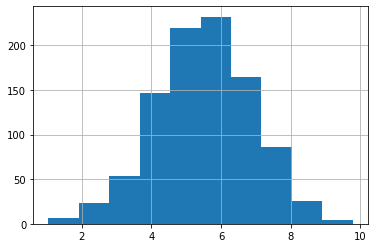

In [15]:
# looks like anya is normally distributed 
# skew and kurtosis near zero, histogram looks normal
from scipy.stats import skew, kurtosis
print(kurtosis(qb['anya']))
print(skew(qb['anya']))
qb['anya'].hist()

## Create Age Curves with "Delta Method"

### Unadjusted Delta Method

In [ ]:
# delta method starts with calculating the change or delta in a metric
# from one year to the next
# here, we will start with adjusted net yards per attempt
# will be easier if we sort the data at the beginning
qb = qb.sort_values(['player_id', 'season_year'])

In [ ]:
# create two new columns
# anya_lag shows the anya from the previous year
# anya_d shows the change in anya from the previous year
# a positive anya_d means improved, negative means regressed
qb['anya_lag'] = qb.groupby(['player_id'])['anya'].shift(1)
qb['anya_d'] = qb['anya'] - qb['anya_lag']

In [ ]:
# the delta method doesn't allow for gaps in seasons
# so we also need to measure the change in season_year
qb['season_lag'] = qb.groupby(['player_id'])['season_year'].shift(1)
qb['season_d'] = qb['season_year'] - qb['season_lag']

In [ ]:
# now we can filter out the na rows
# which are the first row of that player in the dataset
qb = qb.loc[~qb.isna().any(axis=1), :]

In [ ]:
# we can also filter out rows where season_d > 1
# so we ensure consecutive seasons
qb = qb.loc[qb['season_d'] == 1, :]

In [ ]:
# now we'll make a dataframe of age and anya_d
qb_age_curve = (
    qb.groupby('age')['anya_d']
    .agg(['count', 'mean'])
    .reset_index()
)

In [ ]:
qb_age_curve.plot(x='age', y='mean', kind='scatter')

### Weighted Delta Method

In [ ]:
# as before, we will use adjusted net yards / attempt as the metric
# will be easier if we sort the data at the beginning
# that way we can visually see the lag
qb = qb.sort_values(['player_id', 'season_year'])

In [ ]:
# create two new columns
# anya_lag shows the anya from the previous year
# anya_d shows the change in anya from the previous year
# a positive anya_d means improved, negative means regressed
qb['anya_lag'] = qb.groupby(['player_id'])['anya'].shift(1)
qb['anya_d'] = qb['anya'] - qb['anya_lag']

In [ ]:
# the delta method doesn't allow for gaps in seasons
# so we also need to measure the change in season_year
qb['season_lag'] = qb.groupby(['player_id'])['season_year'].shift(1)
qb['season_d'] = qb['season_year'] - qb['season_lag']

In [ ]:
# now we can filter out the na rows
# which are the first row of that player in the dataset
qb = qb.loc[~qb.isna().any(axis=1), :]

In [ ]:
# we can also filter out rows where season_d > 1
# so we ensure consecutive seasons
qb = qb.loc[qb['season_d'] == 1, :]

In [ ]:
qb_age_curve['anya_d_wm'] = (
 qb
 .groupby('age')
 .apply(lambda df_: np.average(df_.anya_d, weights=df_.pass_att))
)

In [ ]:
qb_age_curve

In [ ]:
qb_age_curve.reset_index().plot(x='age', y='weighted_mean', kind='scatter')

In [167]:
# polynomial fit

In [168]:
poly_params = np.polyfit(qb_age_curve.index, qb_age_curve.anya_d_mean, 3)
poly_3 = np.poly1d(poly_params)
xpoly = np.linspace(x.min(), x.max(), 100)
ypoly = poly_3(xpoly)

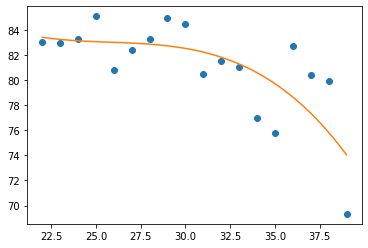

In [169]:
plt.plot(x, y, 'o', xpoly, ypoly)

## Create Age Curves with Peak Method

In [ ]:
# idea here is to identify the player's peak year and then
# express every other season as a % of the player's peak
# so if Manning's best season was 10 aya
# a season with 9.2 aya would be 92 (we are using 1-100 scale)

In [9]:
# as before, we will use adjusted net yards / attempt as the metric
# will be easier if we sort the data at the beginning
# that way we can visually check the calculations
qb = qb.sort_values(['player_id', 'season_year'])

In [10]:
# create two new columns
# peak shows the maximum anya for the player
# normally, groupby produces one row per group
# but we want the peak value for every row
# tranform produces series of the same length as the original series
# so if there are 5 Aikman rows, it sets the peak in all of those rows
display(qb.groupby(['player_id'])['anya'].max().head())
display(qb.groupby(['player_id'])['anya'].transform('max').head())
qb['peak'] = qb.groupby(['player_id'])['anya'].transform('max')

player_id
AikmTr00    7.06
AlleJo02    5.71
AlleKy00    4.76
AndeDe00    6.29
BankTo00    5.46
Name: anya, dtype: float64

22      7.06
117     7.06
236     7.06
2037    5.71
2134    5.71
Name: anya, dtype: float64

In [17]:
# anya_d shows the difference between peak and anya for this row
from math import floor
qb['anya_d'] = qb.apply(lambda df_: floor((df_.anya / df_.peak) * 100), axis=1)

In [174]:
# now we'll make a dataframe of age and anya_d
# we want to use the weighted average of anya_d
# meaning that a QB that throws 600 passes will contribute
# more to the average than one who throws 350 passes.
qb_age_curve = (
    qb.query('(age > 21) & (age < 40)')
    .groupby('age')
    .agg({'anya_d': ['count', 'mean']})
)

In [175]:
qb_age_curve.columns = ['_'.join([el for el in c if el]) 
                        for c in qb_age_curve.columns.to_flat_index()]

In [176]:
poly_params = np.polyfit(qb_age_curve.index, qb_age_curve.anya_d_mean, 3)
poly_3 = np.poly1d(poly_params)
xpoly = np.linspace(x.min(), x.max(), 100)
ypoly = poly_3(xpoly)

([<matplotlib.axis.XTick at 0x7f1fe0c16b90>,
 <a list of 19 Text xticklabel objects>)

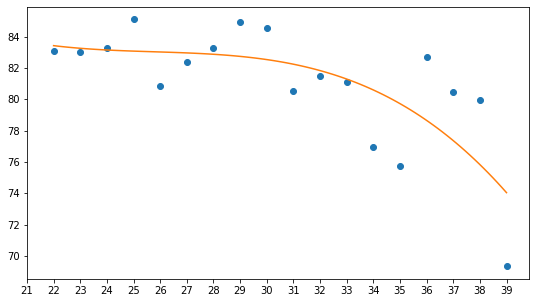

In [183]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(x, y, 'o', xpoly, ypoly)
plt.xticks(range(21, 40))

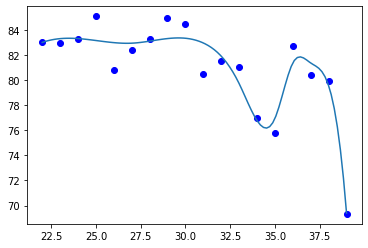

In [189]:
# try the same plot with a spline
x = qb_age_curve.index
y = qb_age_curve['anya_d_mean']
spl = UnivariateSpline(x, y, s=25)
xx = np.linspace(x.min(), x.max(), 100)
plt.plot(x, y, 'bo', xx, spl(xx))

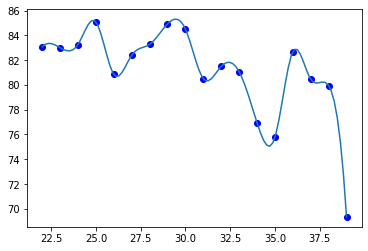

In [190]:
x = qb_age_curve.index
y = qb_age_curve['anya_d_mean']
spl = InterpolatedUnivariateSpline(x, y)
xx = np.linspace(x.min(), x.max(), 100)
plt.plot(x, y, 'bo', xx, spl(xx))

In [204]:
# weighted mean
qb_age_curve['anya_d_wm'] = (
    qb
    .groupby('age')
    .apply(lambda df_: np.average(df_.anya_d, weights=df_.pass_att))
)

In [194]:
x = qb_age_curve.index
y = qb_age_curve.anya_d_wm
poly_params = np.polyfit(x, y, 3)
poly_3 = np.poly1d(poly_params)
xx = np.linspace(x.min(), x.max(), 100)
yy = poly_3(xx)

([<matplotlib.axis.XTick at 0x7f1fe05f2150>,
 <a list of 19 Text xticklabel objects>)

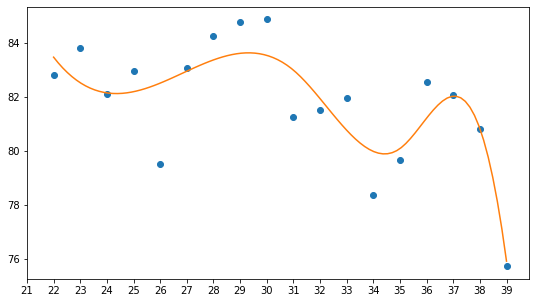

In [201]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(x, y, 'o', xx, yy)
plt.xticks(range(21, 40))

([<matplotlib.axis.XTick at 0x7f1fe057b090>,
 <a list of 19 Text xticklabel objects>)

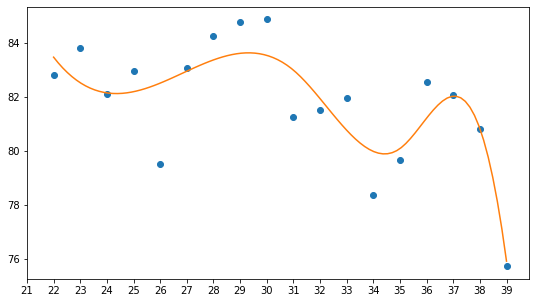

In [202]:
# try the same plot with a spline
x = qb_age_curve.index
y = qb_age_curve['anya_d_wm']
spl = UnivariateSpline(x, y, s=25)
xx = np.linspace(x.min(), x.max(), 100)
yy = spl(xx)
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(x, y, 'o', xx, yy)
plt.xticks(range(21, 40))

([<matplotlib.axis.XTick at 0x7f1fe0507dd0>,
 <a list of 19 Text xticklabel objects>)

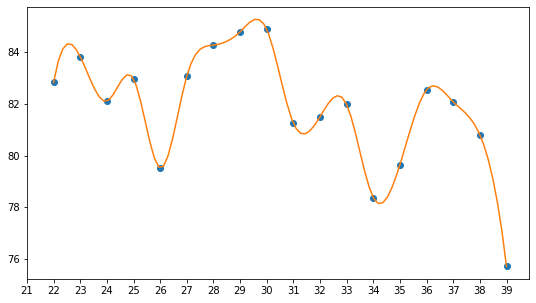

In [203]:
x = qb_age_curve.index
y = qb_age_curve['anya_d_wm']
spl = InterpolatedUnivariateSpline(x, y)
xx = np.linspace(x.min(), x.max(), 100)
yy = spl(xx)
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(x, y, 'o', xx, yy)
plt.xticks(range(21, 40))

## Helper Functions

In [ ]:
# calculate fantasy points
def qb_points(row, add_bonus=False):
    """Calculates qb fantasy points from row in dataframe"""
    # assume 4 points pass TD, 1 point per 25 yards
    # NOTE: our dataset does not have fumbles
    points = 0
    points += row.pass_yds * .04
    points += row.pass_td * 4
    points -= row.pass_int
    points += row.rush_yds * .10
    points += row.rush_td * 6
    if add_bonus and row.pass_yds >= 300:
        points += 3
    return points

In [ ]:
# add fantasy points
def add_fantasy_points(df):
    """Adds fantasy points columns to dataframe"""
    df['fpts'] = df.apply(qb_points, axis=1)
    df['dkpts'] = df.apply(qb_points, args=(True,), axis=1)
    return df

In [ ]:
def yearly_stats(df):
    statcols = ['pass_att', 'pass_cmp', 'pass_int', 'pass_td', 'pass_yds', 'rush_att',
                'rush_td', 'rush_yds', 'air_yards', 'fpts', 'dkpts']
    return df.groupby(['nflid', 'player', 'season_year'])[statcols].sum()

In [ ]:
def age_as_of_game(df):
    """Player age as of game date"""
    # calculate the age by subtracting birthdate from gamedate
    # convert the timedelta to days, then divide by 365
    return df.apply(lambda df_: (df_.game_date - df_.birthdate).days / 365, axis=1)

In [ ]:
def age_as_of_season(df):
    """Player age as of season start (Sept 1)"""
    # create index that is cross join of nflid and seasons
    idx = pd.MultiIndex.from_product(
            [df.nflid.unique(), df.season_year.unique()], 
            names = ["nflid", "season_year"]
    )

    df = pd.DataFrame(idx).reset_index().join(df, how='left', on='nflid')
    return (
        df
        .assign(start_date=lambda df_: df_.season_year.apply(lambda x: datetime(x, 9, 1)))
        .assign(age=lambda df_: df_.apply(lambda row: (row.start_date - row.birthdate).days / 365, axis=1))
        .drop(['birthdate', 'start_date'], axis=1)
        .set_index(['nflid', 'season_year'])
    )
